## AUTO ML CLASSIFICATION MODEL WITH RAPIDS

#### WITHOUT CANADA
#### ALL FEATURES
#### TARGET WITH INFLUENCER MODIFIED and SPLIT BY MEAN *2

In [2]:
!pip install tpot plotly wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 18.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.3/15.3 MB 87.9 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 106.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.8/139.8 kB 44.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.0/169.0 kB 46.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 182.5/182.5 kB 48.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 22.6 MB/s eta 0:00:00
  Created wheel for promise: filename=promise-2.3-py3-none-any.whl size=21503 sha256=8411fc08c87512da86cd48ab0027eb5be1f2d3eb38f11761fd7d7894a606fad2
  Stored in directory: /root/.cache/pip/wheels/e1/e8/83/ddea66100678d139b14bc87692ece57c6a2a937956d2532608
  Created wheel for stopit: filename=stopit-

In [ ]:
# !pip install gdown
# !mkdir data
# !cd data
# !gdown 1D0goLpsXELNET-tzcn_nJutXVBaF-EYR
# !unzip csv_for_ml.zip

In [ ]:
# #!conda init bash
# !conda activate rapids-22.02
# !python3 -c "import cudf, cuml; print(cudf.__version__); print(cuml.__version__)"
# !conda deactivate

In [1]:
import pandas as pd
from functools import reduce
import wandb
wandb.init(project="henry-tf-g2-ml1")
import tpot

wandb: Currently logged in as: maico (hayequipo). Use `wandb login --relogin` to force relogin


/opt/conda/envs/rapids/lib/python3.9/site-packages/tpot/builtins/__init__.py:36: UserWarning: Warning: optional dependency `torch` is not available. - skipping import of NN models.
  warnings.warn("Warning: optional dependency `torch` is not available. - skipping import of NN models.")


In [49]:
business = pd.read_csv('./data/business.csv')
attributes = pd.read_csv('./data/atributtes_clean.csv', low_memory=False)
categories = pd.read_csv('./data/categories_fixed.csv')
hours = pd.read_csv('./data/hours_fixed.csv')
gps = pd.read_csv('./data/gps_clustering_fixed.csv')
checkins = pd.read_csv('./data/n_checkins.csv')
top_tips = pd.read_csv('./data/top_tips.csv')
target1 = pd.read_csv('./data/target.csv')
target2 = pd.read_csv('./data/target2.csv')
target3 = pd.read_csv('./data/target_3_influencer_modified.csv')
sentiment = pd.read_csv('./data/sentiment_ok_unique.csv')

In [50]:
target3['target'].value_counts()

0    119879
1     30467
Name: target, dtype: int64

In [51]:
target3['target'] = 0
target3.loc[target3['success_score'] >= target3['success_score'].mean() * 2,'target'] = 1

In [52]:
data_frames = [business, attributes, categories, hours, gps, checkins, top_tips, target3]
full_data_2 = reduce(lambda left,right: pd.merge(left,right,on='business_id', how='left'), data_frames)

In [53]:
full_data_2.columns

Index(['business_id', 'name', 'postal_code', 'latitude_x', 'longitude_x',
       'stars', 'review_count_x', 'is_open', 'good_ambience', 'garage',
       'BusinessAcceptsCreditCards', 'RestaurantsPriceRange2', 'BikeParking',
       'WiFi', 'delivery', 'GoodForKids', 'OutdoorSeating',
       'RestaurantsReservations', 'HasTV', 'RestaurantsGoodForGroups',
       'Alcohol', 'ByAppointmentOnly', 'Caters', 'RestaurantsAttire',
       'NoiseLevel', 'meal_diversity', 'Restaurants', 'Food', 'Shopping',
       'Home Services', 'Beauty & Spas', 'Nightlife', 'Health & Medical',
       'Local Services', 'Bars', 'Automotive', 'total_categories', '7days',
       'weekends', 'n_open_days', 'mean_total_hours_open', 'mean_open_hour',
       'mean_close_hour', 'latitude_y', 'longitude_y', 'latlong_div', 'areas',
       'number_visits', 'number_tips', 'Unnamed: 0', 'review_count_y',
       'avg(reactions)', 'avg(stars)', 'avg(Influencer_2)', 'success_score',
       'target'],
      dtype='object')

In [54]:
to_drop = ['name', 'postal_code', 'latitude_x', 'longitude_x', 'stars',
 'review_count_x', 'is_open', 'latitude_y', 'longitude_y',  'number_visits', 
 'number_tips', 'Unnamed: 0', 'review_count_y','avg(reactions)', 'avg(stars)', 
 'avg(Influencer_2)', 'success_score',
 'total_categories', '7days', 'n_open_days', 'mean_open_hour', 'mean_close_hour'
 ,'latlong_div']
full_data_2.drop(to_drop, inplace=True, axis=1)

In [55]:
full_data_2 = full_data_2.loc[full_data_2['areas'] != 8, :]

In [56]:
full_data_2.index = full_data_2['business_id']
full_data_2.drop('business_id', axis=1, inplace=True)

In [57]:
full_data_2.columns

Index(['good_ambience', 'garage', 'BusinessAcceptsCreditCards',
       'RestaurantsPriceRange2', 'BikeParking', 'WiFi', 'delivery',
       'GoodForKids', 'OutdoorSeating', 'RestaurantsReservations', 'HasTV',
       'RestaurantsGoodForGroups', 'Alcohol', 'ByAppointmentOnly', 'Caters',
       'RestaurantsAttire', 'NoiseLevel', 'meal_diversity', 'Restaurants',
       'Food', 'Shopping', 'Home Services', 'Beauty & Spas', 'Nightlife',
       'Health & Medical', 'Local Services', 'Bars', 'Automotive', 'weekends',
       'mean_total_hours_open', 'areas', 'target'],
      dtype='object')

In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate

from sklearn.pipeline import Pipeline

from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import recall_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score

from sklearn.utils import class_weight

from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier

#from functions import run_exps

import warnings
warnings.filterwarnings('ignore') 

In [59]:
# Imputing with MICE
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn import linear_model

# Define MICE Imputer and fill missing values
mice_imputer = IterativeImputer(estimator=linear_model.BayesianRidge(), n_nearest_features=None, imputation_order='ascending')

full_data_2['mean_total_hours_open'] = mice_imputer.fit_transform(full_data_2['mean_total_hours_open'].values.reshape(-1,1))

In [60]:
full_data_2.fillna(0, inplace=True)

In [61]:
full_data_3 = full_data_2.copy()

In [62]:
ohe = OneHotEncoder(sparse=False)
to_transform = ['areas', 'RestaurantsPriceRange2']
X = ohe.fit_transform(full_data_2[to_transform])
X = pd.DataFrame(X, columns=ohe.get_feature_names(to_transform), index=full_data_2.index)
full_data_2 = pd.concat([full_data_2, X], axis=1)
full_data_2.drop(to_transform, axis=1, inplace=True)

In [63]:
full_data_2.shape

(144773, 45)

In [64]:
full_data_2.isna().sum().sum()

0

In [65]:
full_data_2['meal_diversity'].unique()

array([0, 1, 2, 4, 3, 5, 6])

In [66]:
full_data_2.columns.tolist()

['good_ambience',
 'garage',
 'BusinessAcceptsCreditCards',
 'BikeParking',
 'WiFi',
 'delivery',
 'GoodForKids',
 'OutdoorSeating',
 'RestaurantsReservations',
 'HasTV',
 'RestaurantsGoodForGroups',
 'Alcohol',
 'ByAppointmentOnly',
 'Caters',
 'RestaurantsAttire',
 'NoiseLevel',
 'meal_diversity',
 'Restaurants',
 'Food',
 'Shopping',
 'Home Services',
 'Beauty & Spas',
 'Nightlife',
 'Health & Medical',
 'Local Services',
 'Bars',
 'Automotive',
 'weekends',
 'mean_total_hours_open',
 'target',
 'areas_0',
 'areas_1',
 'areas_2',
 'areas_3',
 'areas_4',
 'areas_5',
 'areas_6',
 'areas_7',
 'areas_9',
 'areas_10',
 'RestaurantsPriceRange2_0',
 'RestaurantsPriceRange2_1',
 'RestaurantsPriceRange2_2',
 'RestaurantsPriceRange2_3',
 'RestaurantsPriceRange2_4']

In [67]:
full_data_2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 144773 entries, Pns2l4eNsfO8kk83dixA6A to jV_XOycEzSlTx-65W906pg
Data columns (total 45 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   good_ambience               144773 non-null  int64  
 1   garage                      144773 non-null  int64  
 2   BusinessAcceptsCreditCards  144773 non-null  int64  
 3   BikeParking                 144773 non-null  int64  
 4   WiFi                        144773 non-null  int64  
 5   delivery                    144773 non-null  int64  
 6   GoodForKids                 144773 non-null  int64  
 7   OutdoorSeating              144773 non-null  int64  
 8   RestaurantsReservations     144773 non-null  int64  
 9   HasTV                       144773 non-null  int64  
 10  RestaurantsGoodForGroups    144773 non-null  int64  
 11  Alcohol                     144773 non-null  int64  
 12  ByAppointmentOnly           144773 non-n

In [68]:
X_train, X_test, y_train, y_test = train_test_split(
    full_data_2.drop('target', axis=1), full_data_2['target'], test_size=0.2,
    random_state=42)

In [69]:
pipeline_optimizer = tpot.TPOTClassifier(generations=15, #number of iterations to run the training
                                        population_size=20, #number of individuals to train
                                        cv=10, max_time_mins = 100,
                                        config_dict="TPOT cuML") #number of folds in StratifiedKFold
pipeline_optimizer.fit(X_train, y_train) #fit the pipeline optimizer - can take a long time

print(pipeline_optimizer.score(X_test, y_test)) #print scoring for the pipeline
pipeline_optimizer.export('automl_pipeline_gpu_class_9_v3.py') #export the pipeline - in Python code!

In [ ]:
print(XXXXX)

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, make_union
from tpot.builtins import StackingEstimator, ZeroCount
from xgboost import XGBClassifier
from sklearn.preprocessing import FunctionTransformer
from copy import copy


exported_pipeline = XGBClassifier(alpha=1, learning_rate=0.1, max_depth=8, min_child_weight=7, n_estimators=100, n_jobs=1, subsample=0.6000000000000001, tree_method="gpu_hist", verbosity=0)

exported_pipeline.fit(X_train, y_train)
results = exported_pipeline.predict(X_test)

In [ ]:
import wandb
wandb.login()

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


True

In [ ]:
# import numpy as np
# import pandas as pd
# from sklearn.model_selection import train_test_split
# from sklearn.pipeline import make_pipeline
# from xgboost import XGBClassifier
# from sklearn.feature_selection import SelectFwe, f_classif

# # Average CV score on the training set was: 0.8492544987146529
# # Average CV score on the training set was: 0.9022107969151673
# exported_pipeline = XGBClassifier(alpha=1, learning_rate=0.1, max_depth=8, min_child_weight=2, n_estimators=100, n_jobs=1, subsample=1.0, tree_method="gpu_hist", verbosity=0)

# exported_pipeline.fit(X_train, y_train)
# results = exported_pipeline.predict(X_test)

In [ ]:
exported_pipeline.get_booster().feature_names

['good_ambience',
 'garage',
 'BusinessAcceptsCreditCards',
 'BikeParking',
 'WiFi',
 'delivery',
 'GoodForKids',
 'OutdoorSeating',
 'RestaurantsReservations',
 'HasTV',
 'RestaurantsGoodForGroups',
 'Alcohol',
 'ByAppointmentOnly',
 'Caters',
 'RestaurantsAttire',
 'NoiseLevel',
 'meal_diversity',
 'Restaurants',
 'Food',
 'Shopping',
 'Home Services',
 'Beauty & Spas',
 'Nightlife',
 'Health & Medical',
 'Local Services',
 'Bars',
 'Automotive',
 'weekends',
 'mean_total_hours_open',
 'latlong_div',
 'areas_0',
 'areas_1',
 'areas_2',
 'areas_3',
 'areas_4',
 'areas_5',
 'areas_6',
 'areas_7',
 'areas_9',
 'areas_10',
 'RestaurantsPriceRange2_0',
 'RestaurantsPriceRange2_1',
 'RestaurantsPriceRange2_2',
 'RestaurantsPriceRange2_3',
 'RestaurantsPriceRange2_4']

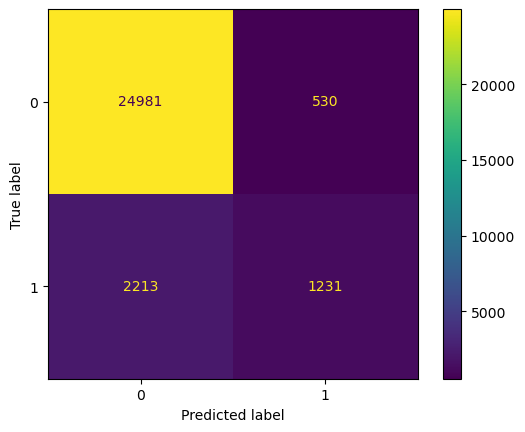

[[24981   530]
 [ 2213  1231]]
              precision    recall  f1-score   support

           0       0.92      0.98      0.95     25511
           1       0.70      0.36      0.47      3444

    accuracy                           0.91     28955
   macro avg       0.81      0.67      0.71     28955
weighted avg       0.89      0.91      0.89     28955



In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

matrix = confusion_matrix(y_test, results)
cm_display = ConfusionMatrixDisplay(matrix)
cm_display.plot()
plt.show()

from sklearn.metrics import classification_report, confusion_matrix
print(confusion_matrix(y_test, results))
print(classification_report(y_test, results))

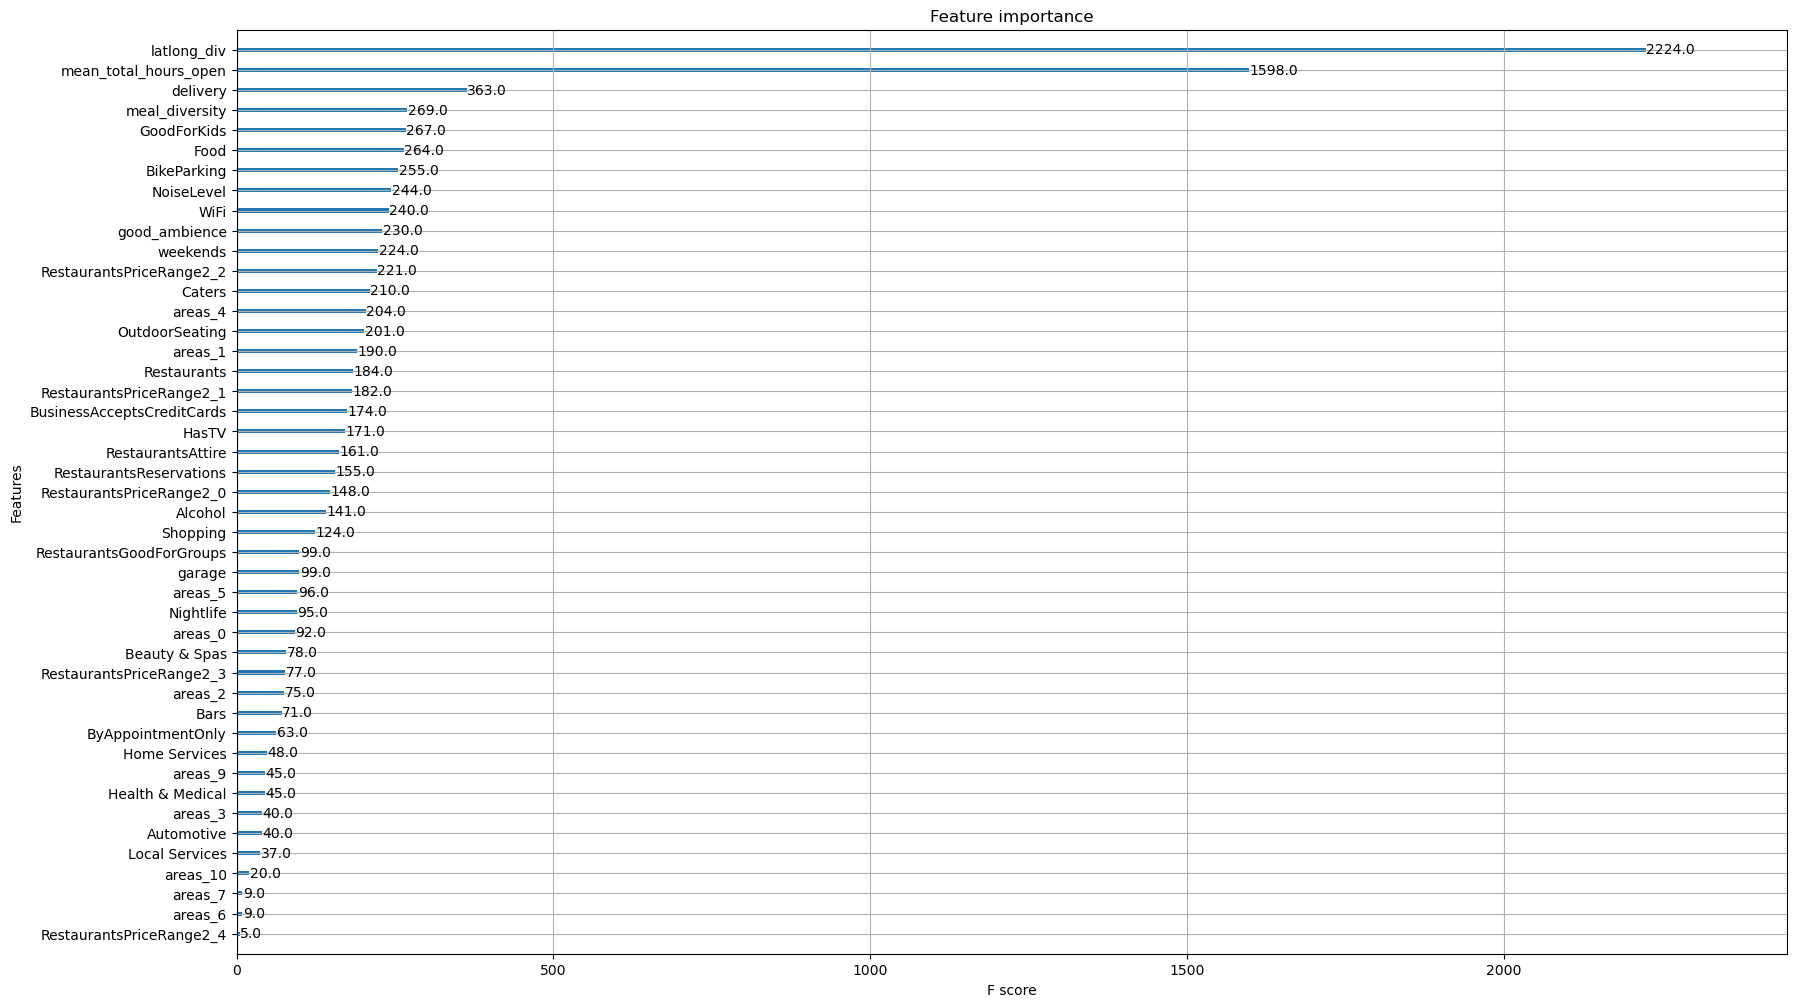

In [ ]:
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore') 
# Plot the feature importances
fig, ax = plt.subplots(figsize=(20, 12))
xgb.plot_importance(exported_pipeline, ax=ax)
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, results)

In [ ]:
wandb.summary["accuracy"] = accuracy

In [ ]:
# Visualize single plot
wandb.sklearn.plot_confusion_matrix(y_test, results)

In [ ]:
import pickle
file_name = "xgb_business_v2.pkl"

# save
pickle.dump(exported_pipeline, open(file_name, "wb"))